In [152]:
pip install zarr-eosdis-store pqdm cartopy shapely

Note: you may need to restart the kernel to use updated packages.


In [153]:
from eosdis_store import EosdisStore
import xarray as xr
import requests
from pqdm.threads import pqdm
import pandas as pd
from matplotlib import animation, pyplot as plt
from IPython.core.display import display, HTML
import warnings
from pprint import pprint
import numpy as np
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from shapely.geometry import box, Polygon, MultiPolygon
from shapely.ops import unary_union
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib.patches import Polygon as mplPolygon
import matplotlib.ticker as mticker
import numpy as np
import shapely
from shapely.geometry import LineString, Point
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
from shapely.ops import substring

/tmp/ipykernel_42/1238793677.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [154]:
plt.rcParams['figure.figsize'] = 12, 6
data_provider = 'POCLOUD'
mur_short_name = 'MUR-JPL-L4-GLOB-v4.1'

In [155]:
start_time = '2021-07-01T21:00:00Z'
end_time = '2021-07-20T20:59:59Z'

lats = slice(-5, 35)
lons = slice(45, 90)

In [156]:
cmr_url = 'https://cmr.earthdata.nasa.gov/search/granules.json'

In [157]:
response = requests.get(cmr_url,
                        params={
                            'provider': data_provider,
                            'short_name': mur_short_name,
                            'temporal': f'{start_time},{end_time}',
                            'bounding_box': f'{lons.start},{lats.start},{lons.stop},{lats.stop}',
                            'page_size': 2000,
                            }
                       )

In [158]:
granules = response.json()['feed']['entry']
print(len(granules))

20


In [159]:
urls = []
for granule in granules:
    for link in granule['links']:
        if link['rel'].endswith('/data#'):
            urls.append(link['href'])
            break
pprint(urls)

['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210701090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210702090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210703090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210704090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210705090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210706090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cum

In [160]:
response = requests.head(f'{urls[0]}.dmrpp')

print('Can we use EosdisZarrStore and XArray to access these files more efficiently?')
print('Yes' if response.ok else 'No')

Can we use EosdisZarrStore and XArray to access these files more efficiently?
Yes


In [161]:
df_raw = pd.DataFrame()

# if not os.path.exists("saved_sst2"):
#     os.makedirs("saved_sst2")
for i in range(len(urls)):
    ds = xr.open_zarr(EosdisStore(urls[i]), consolidated=False)
    sst = ds.analysed_sst.sel(lat=lats, lon=lons)

    # turn sst to DataFrame
    df_sst = sst.to_dataframe().reset_index()

    # add df_sst to df_raw
    df_raw = pd.concat([df_raw, df_sst])
    break
    # plt.figure()
    # sst.plot()
    # plt.savefig(f"saved_sst2/sst_{i}.png")
    # plt.close()
    # del sst
    # gc.collect()

/srv/conda/envs/notebook/lib/python3.9/site-packages/zarr/storage.py:2919: UserWarning: Store {'.zgroup': {'zarr_format': 2}, 'mask/.zarray': {'zarr_format': 2, 'filters': [{'id': 'shuffle', 'elementsize': 2}], 'order': 'C', 'dtype': '<i2', 'shape': [1, 17999, 36000], 'compressor': {'id': 'zlib', 'level': 4}, 'chunks': [1, 1447, 2895], 'fill_value': -128}, 'mask/.zattrs': {'long_name': 'sea/land field composite mask', '_FillValue': -128, 'valid_min': 1, 'valid_max': 31, 'flag_masks': [1, 2, 4, 8, 16], 'flag_meanings': 'open_sea land open_lake open_sea_with_ice_in_the_grid open_lake_with_ice_in_the_grid', 'comment': 'mask can be used to further filter the data.', 'coordinates': 'lon lat', 'source': 'GMT \\"grdlandmask\\", ice flag from sea_ice_fraction data', '_ARRAY_DIMENSIONS': ['time', 'lat', 'lon']}, 'mask/.zchunkstore': {'0.0.0': {'offset': 336902366, 'size': 6426}, '0.0.1': {'offset': 336908792, 'size': 4981}, '0.0.2': {'offset': 336913773, 'size': 4083}, '0.0.3': {'offset': 33691

In [162]:
df_raw

,time,lat,lon,analysed_sst
0,2021-07-01 09:00:00,-5.0,45.000000,299.786987
1,2021-07-01 09:00:00,-5.0,45.009998,299.790985
2,2021-07-01 09:00:00,-5.0,45.020000,299.790985
3,2021-07-01 09:00:00,-5.0,45.029999,299.789001
4,2021-07-01 09:00:00,-5.0,45.040001,299.782990
...,...,...,...,...
18008496,2021-07-01 09:00:00,35.0,89.959999,NaN
18008497,2021-07-01 09:00:00,35.0,89.970001,NaN
18008498,2021-07-01 09:00:00,35.0,89.980003,NaN
18008499,2021-07-01 09:00:00,35.0,89.989998,NaN


/tmp/ipykernel_42/340439664.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  coastline = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


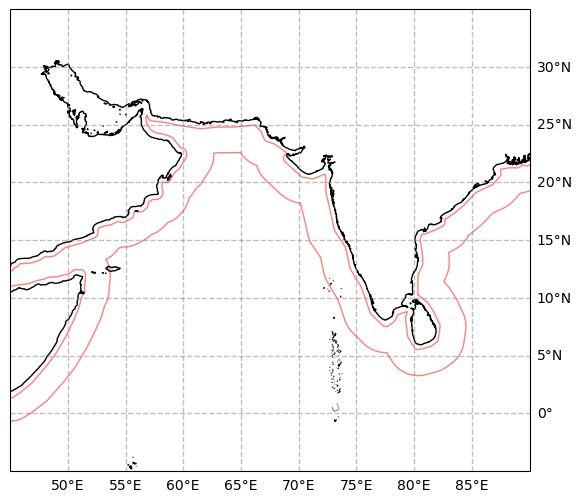

In [164]:
crs = ccrs.PlateCarree()

coastline = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Define bounding box and convert to a GeoDataFrame
bbox = Polygon([(lons.start, lats.start), (lons.start, lats.stop), (lons.stop, lats.stop), (lons.stop, lats.start)])
bbox_gdf = gpd.GeoDataFrame(gpd.GeoSeries(bbox), columns=['geometry'])
bbox_gdf.set_crs('EPSG:4326', inplace=True)

# Clip the coastline with the bounding box
coastline_clipped = gpd.clip(coastline, bbox_gdf)

# Convert the clipped coastline to UTM zone 43N
coastline_utm_clipped = coastline_clipped.to_crs('EPSG:32643')

distances = [50000, 300000]

# Create buffered geometries
buffered = []
for distance in distances:
    buffer = coastline_utm_clipped.buffer(distance)
    buffered.append(buffer)

# Convert buffered geometries to a GeoDataFrame, unify them, set CRS and transform to WGS84 CRS
buffered_gdfs = []
for b in buffered:
    unified = shapely.ops.unary_union(b)
    gdf = gpd.GeoDataFrame(gpd.GeoSeries(unified), columns=['geometry'])
    gdf.set_crs('EPSG:32643', inplace=True)  # Set the CRS to UTM zone 43N
    buffered_gdfs.append(gdf)

buffered_wgs84 = [gdf.to_crs('EPSG:4326') for gdf in buffered_gdfs]  # Convert to WGS84

# Unify all buffered geometries
union_buffered = unary_union(buffered)

# Plotting
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lons.start, lons.stop, lats.start, lats.stop], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m', color='black', linewidth=1)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.left_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(range(int(lons.start), int(lons.stop)+1, 5))   # Set longitude markers every 5 degrees
gl.ylocator = mticker.FixedLocator(range(int(lats.start), int(lats.stop)+1, 5))   # Set latitude markers every 5 degrees

# Plot buffers
for buf in buffered_wgs84:
    for geom in buf.geometry:
        if geom.is_empty:
            continue
        if geom.geom_type == 'Polygon':
            geom = MultiPolygon([geom])
        for polygon in geom.geoms:
            x, y = polygon.exterior.coords.xy
            coords = np.column_stack((x, y))
            mpl_poly = mplPolygon(coords, edgecolor='red', facecolor='none', alpha=0.5)
            ax.add_patch(mpl_poly)

# Set the axes limits to your bounding box
ax.set_xlim([lons.start, lons.stop])
ax.set_ylim([lats.start, lats.stop])

plt.show()

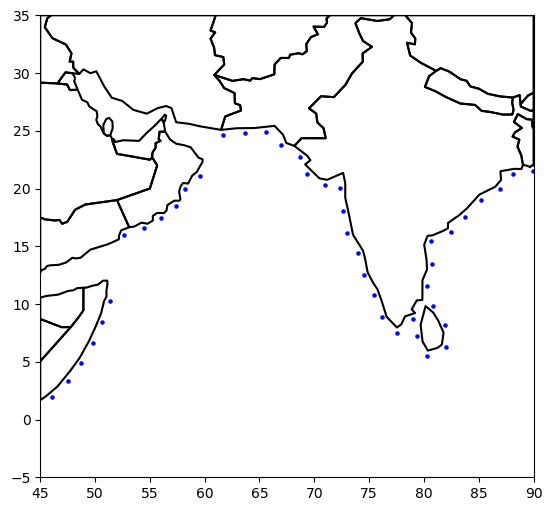

In [165]:
# Find the points in the 100km buffer
def sample_points(buffer_gdf, dist):
    sampled_points = gpd.GeoDataFrame(columns=['geometry'])

    for geom in buffer_gdf.geometry:
        boundary = geom.boundary
        length = boundary.length
        num_points = int(length / dist)
        for i in range(num_points):
            fraction = i / num_points

            point = boundary.interpolate(fraction, normalized=True)

            sampled_points.loc[len(sampled_points)] = Point(point)

    return sampled_points

temp = 2
sampled_points_100km = sample_points(buffered_wgs84[0], temp)
lats_bounds = [-5, 35]
lons_bounds = [45, 90]

# Noise Removal
sampled_points_100km = sampled_points_100km[
    (sampled_points_100km.geometry.y >= lats_bounds[0]) &
    (sampled_points_100km.geometry.y <= lats_bounds[1]) &
    (sampled_points_100km.geometry.x >= lons_bounds[0]) &
    (sampled_points_100km.geometry.x <= lons_bounds[1])
]
sampled_points_100km = sampled_points_100km[~((sampled_points_100km.geometry.y >= 24) & 
                                              (sampled_points_100km.geometry.y < 30) &
                                              (sampled_points_100km.geometry.x > 45) &
                                              (sampled_points_100km.geometry.x <= 57))]
sampled_points_100km = sampled_points_100km[~((sampled_points_100km.geometry.y >= 11) & 
                                              (sampled_points_100km.geometry.y < 15) &
                                              (sampled_points_100km.geometry.x > 45) &
                                              (sampled_points_100km.geometry.x <= 52))]
sampled_points_100km = sampled_points_100km[~((sampled_points_100km.geometry.y >= 22) & 
                                              (sampled_points_100km.geometry.y < 27) &
                                              (sampled_points_100km.geometry.x > 55) &
                                              (sampled_points_100km.geometry.x <= 61))]

# reindex
sampled_points_100km = sampled_points_100km.reset_index(drop=True)

fig, ax = plt.subplots()
sampled_points_100km.plot(ax=ax, color='blue', markersize=5)
coastline_clipped.boundary.plot(ax=ax, color='black')
plt.xlim([45, 90])
plt.ylim([-5, 35])

plt.show()

In [166]:
def get_nearest_points(source_points, candidate_points, lons_bounds, lats_bounds):
    nearest_points = gpd.GeoDataFrame(columns=['geometry'])

    # Only keep candidate_points that are within the bounding box
    candidate_points = candidate_points[
        (candidate_points.geometry.y >= lats_bounds[0]) &
        (candidate_points.geometry.y <= lats_bounds[1]) &
        (candidate_points.geometry.x >= lons_bounds[0]) &
        (candidate_points.geometry.x <= lons_bounds[1])
    ]
    
    for i, source_point in enumerate(source_points.geometry):
        # Compute distances from source_point to all candidate_points
        distances = candidate_points.distance(source_point)

        # Find the index of the nearest point
        nearest_point_index = distances.idxmin()

        nearest_point = candidate_points.loc[nearest_point_index]

        # Append the nearest point to the GeoDataFrame
        nearest_points.loc[i] = nearest_point

    return nearest_points

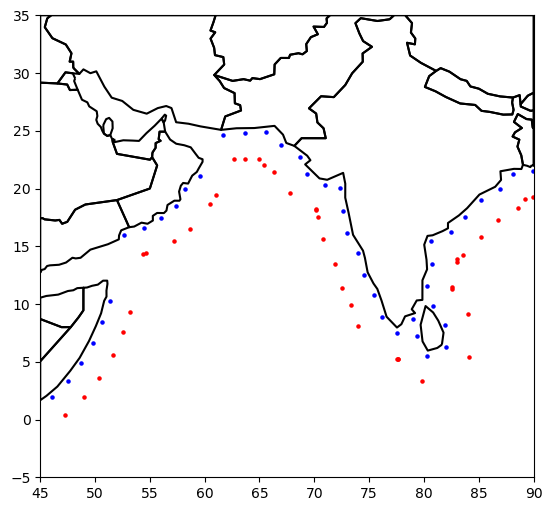

In [167]:
# Get all points on the boundary of the 300km buffer
def generate_points(line, distance):
    total_length = line.length
    distances = np.arange(0, total_length, distance)
    points = [line.interpolate(d) for d in distances]
    return points

all_points_300km = []
for boundary in buffered_wgs84[1].boundary:
    if boundary.geom_type == 'LineString':
        lines = [boundary]
    elif boundary.geom_type == 'MultiLineString':
        lines = boundary
    for line in lines:
        points = generate_points(line, 0.01) # Adjust the distance here
        all_points_300km.extend(points)
all_points_300km_gdf = gpd.GeoDataFrame(gpd.GeoSeries(all_points_300km), columns=['geometry'])

# all_points_300km = [Point(x, y) for line in buffered_wgs84[1].boundary for x, y in line.coords]
# all_points_300km_gdf = gpd.GeoDataFrame(gpd.GeoSeries(all_points_300km), columns=['geometry'])

# Find the nearest points on the 300km buffer for each point on the 100km buffer
nearest_points = get_nearest_points(sampled_points_100km, all_points_300km_gdf,
                                    lons_bounds, lats_bounds)

fig, ax = plt.subplots()
nearest_points.plot(ax=ax, color='red', markersize=5)
sampled_points_100km.plot(ax=ax, color='blue', markersize=5)
coastline_clipped.boundary.plot(ax=ax, color='black')
plt.xlim([45, 90])
plt.ylim([-5, 35])

plt.show()

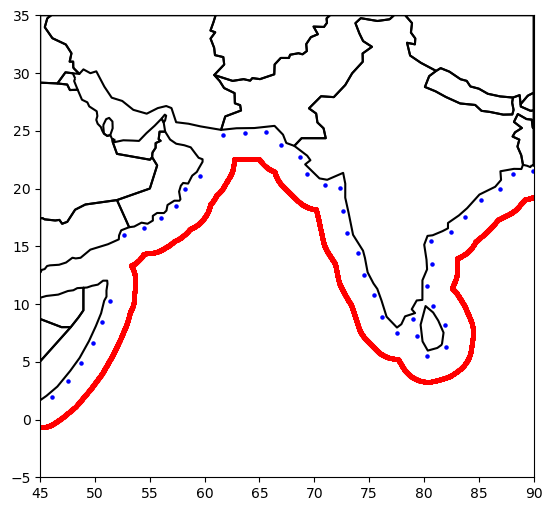

In [168]:
# Visualize the entire set of points on the 300km buffer
fig, ax = plt.subplots()
all_points_300km_gdf.plot(ax=ax, color='red', markersize=5)
sampled_points_100km.plot(ax=ax, color='blue', markersize=5)
coastline_clipped.boundary.plot(ax=ax, color='black')
plt.xlim([45, 90])
plt.ylim([-5, 35])

plt.show()

In [169]:
# Build the KD-tree using lon/lat from df_raw
coordinates = df_raw[['lon', 'lat']].values
tree = cKDTree(coordinates)

def find_nearest_sst(point, tree, df):
    lon, lat = point.x, point.y
    _, idx = tree.query(np.array([lon, lat]), k=1)
    nearest_sst = df.iloc[idx]['analysed_sst']
    return nearest_sst

def get_sst_difference(df, points1, points2, tree):
    sst_diff = []
    for point1, point2 in zip(points1.geometry, points2.geometry):
        sst1 = find_nearest_sst(point1, tree, df)
        sst2 = find_nearest_sst(point2, tree, df)
        sst_diff.append(abs(sst1 - sst2))
    return sst_diff

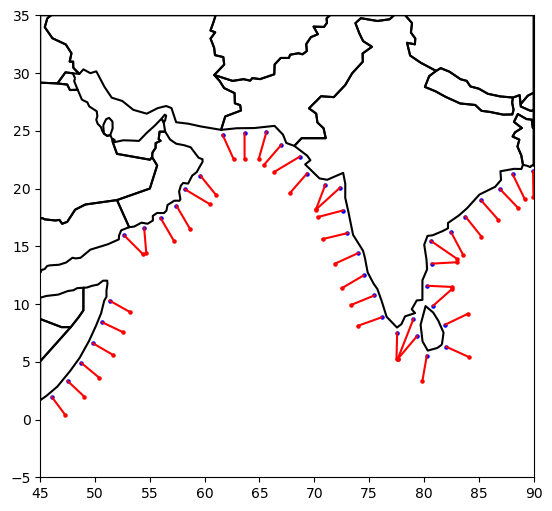

In [170]:
threshold = 0.01

# Get SST differences
sst_diff = get_sst_difference(df_raw, sampled_points_100km, nearest_points, tree)
exceeded_threshold_indices = [i for i, diff in zip(sampled_points_100km.index, sst_diff) if diff > threshold]

fig, ax = plt.subplots()
for i in exceeded_threshold_indices:
    point1 = sampled_points_100km.geometry.loc[i]
    point2 = nearest_points.geometry.loc[i]
    line = LineString([point1, point2])
    xs, ys = line.xy
    ax.plot(xs, ys, color='red')

sampled_points_100km.plot(ax=ax, color='blue', markersize=5)
nearest_points.plot(ax=ax, color='red', markersize=5)
coastline_clipped.boundary.plot(ax=ax, color='black')
plt.xlim([45, 90])
plt.ylim([-5, 35])
plt.show()

In [207]:
from matplotlib.colors import LinearSegmentedColormap
def plot_sst(df, sampled_points, nearest_points, threshold, tree):
    # Reshape data into 2D for the SST plot
    data = df.pivot(index='lat', columns='lon', values='analysed_sst').copy()

    # Get SST differences
    sst_diff = get_sst_difference(df, sampled_points, nearest_points, tree)
    exceeded_threshold_indices = [i for i, diff in zip(sampled_points.index, sst_diff) if diff > threshold]

    fig, ax = plt.subplots()
    
    # Attempt to define a color bar
    cmap = LinearSegmentedColormap.from_list("erddap_rainbow", 
        [(0, 'purple'), 
         (0.125, 'blue'), 
         (0.375, 'cyan'),
         (0.625, 'yellow'),
         (0.875, 'orange'),
         (1, 'red')])

    # Using cmap=jet to simulate the default 'rainbow' color map of ERDDAP
    plt.contourf(data.columns, data.index, data.values, cmap='rainbow_r', levels=np.arange(290, 310.5, 0.5))
    cbar = plt.colorbar(label='SST')
    
    for i in exceeded_threshold_indices:
        point1 = sampled_points.geometry.loc[i]
        point2 = nearest_points.geometry.loc[i]
        line = LineString([point1, point2])
        xs, ys = line.xy
        ax.plot(xs, ys, color='red')

    # Plot sampled points and nearest points
    sampled_points.plot(ax=ax, color='blue', markersize=5)
    nearest_points.plot(ax=ax, color='red', markersize=5)
    
    # Plot coastline
    coastline_clipped.boundary.plot(ax=ax, color='black')
    
    # Set plot limits
    plt.xlim([45, 90])
    plt.ylim([-5, 35])
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Sea Surface Temperature and Upwelling Locations')
    plt.show()

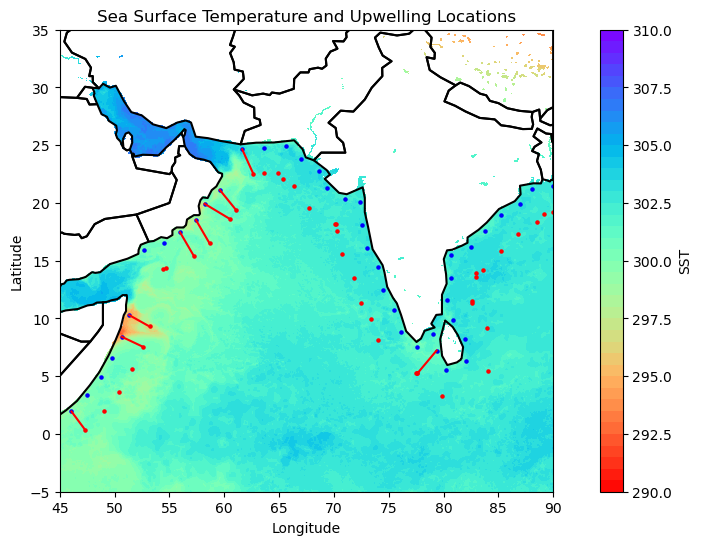

In [208]:
# df_raw['time'] = pd.to_datetime(df_raw['time'])
# grouped = df_raw.groupby(df_raw['time'].dt.date)
# plot_sst(grouped, sampled_points_100km, nearest_points, 0.15, tree)
plot_sst(df_raw, sampled_points_100km, nearest_points, 1, tree)
# for date, group in grouped:
#     coords = group[['lon', 'lat']].values
#     tree = cKDTree(coords)
#     plot_sst(group, sampled_points_100km, nearest_points, 0.15, tree)